In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
%cd /content/

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train=pd.read_csv('train.csv')

In [ ]:
train.head()

,image_id,breed
0,a8b3ad1dde.jpg,nerodia-erythrogaster
1,8b492b973d.jpg,pantherophis-vulpinus
2,929b99ea92.jpg,thamnophis-sirtalis
3,bbac7385e2.jpg,pantherophis-obsoletus
4,ef776b1488.jpg,agkistrodon-contortrix


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5508 entries, 0 to 5507
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  5508 non-null   object
 1   breed     5508 non-null   object
dtypes: object(2)
memory usage: 86.2+ KB


In [ ]:
train.breed.value_counts()

thamnophis-sirtalis            509
storeria-dekayi                412
pantherophis-obsoletus         366
crotalus-atrox                 354
pituophis-catenifer            298
nerodia-sipedon                259
agkistrodon-contortrix         206
lampropeltis-triangulum        197
diadophis-punctatus            184
pantherophis-alleghaniensis    172
nerodia-erythrogaster          171
lampropeltis-californiae       166
opheodrys-aestivus             152
agkistrodon-piscivorus         147
crotalus-horridus              142
coluber-constrictor            129
heterodon-platirhinos          118
thamnophis-proximus            112
nerodia-rhombifer              104
pantherophis-guttatus          100
thamnophis-radix               100
haldea-striatula                98
pantherophis-spiloides          92
rhinocheilus-lecontei           91
storeria-occipitomaculata       87
crotalus-viridis                83
masticophis-flagellum           83
thamnophis-marcianus            82
crotalus-ruber      

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


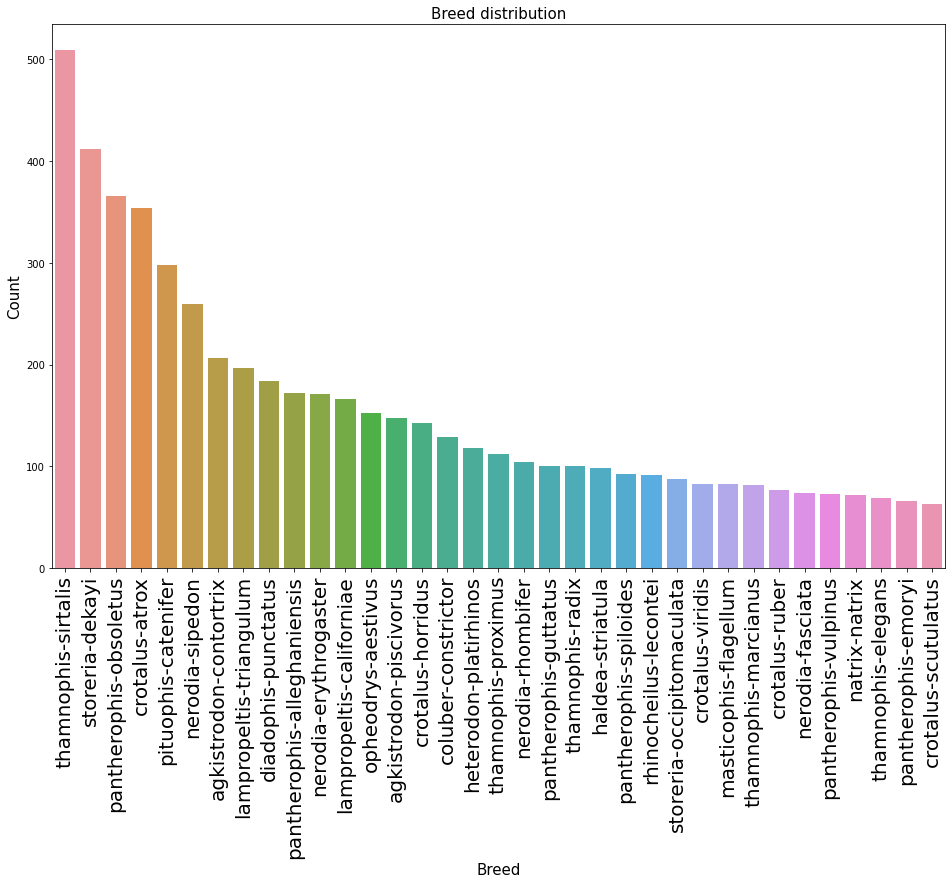

In [ ]:
plt.figure(figsize=(16,10))
sns.countplot(train.breed,order=(train.breed.value_counts().index))
plt.ylabel('Count',fontsize=15)
plt.xlabel("Breed", fontsize =15)
plt.title('Breed distribution',fontsize=15)
plt.xticks(rotation=90,fontsize=20)
plt.show()

In [4]:
for i in range(len(train['image_id'])):
    train['image_id'][i]=train['image_id'][i]+'.jpg'
    

In [5]:
train.head()

,image_id,breed
0,a8b3ad1dde.jpg,nerodia-erythrogaster
1,8b492b973d.jpg,pantherophis-vulpinus
2,929b99ea92.jpg,thamnophis-sirtalis
3,bbac7385e2.jpg,pantherophis-obsoletus
4,ef776b1488.jpg,agkistrodon-contortrix


In [6]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical

In [24]:
%cd /content/drive/MyDrive/train/

/content/drive/MyDrive/train


In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
         shear_range=0.2,
        zoom_range=0.2,
         horizontal_flip=True,
         width_shift_range=0.1,
         height_shift_range=0.1)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory=None,
x_col="image_id",
y_col="breed",
subset="training",
batch_size=128,
seed=12,
shuffle=True,
class_mode="categorical",
target_size=(299,299))

Found 5508 validated image filenames belonging to 35 classes.


In [9]:
resnet=InceptionResNetV2(include_top=True,weights='imagenet')

225214464/225209952 [==============================] - 1s 0us/step


In [10]:
x=resnet.layers[-2].output
fc1=Dense(35,activation='softmax')(x)

In [11]:
model=Model(inputs=resnet.input,outputs=fc1)

In [12]:
for l in model.layers[:-35]:
    #print(l)
    l.trainable = False

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()    

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
model.fit_generator(train_generator,epochs=3,steps_per_epoch=5508//128)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
43/43 [==============================] - 1279s 30s/step - loss: 2.7745 - accuracy: 0.2535
Epoch 2/3
43/43 [==============================] - 114s 3s/step - loss: 2.0878 - accuracy: 0.3896
Epoch 3/3
43/43 [==============================] - 114s 3s/step - loss: 1.7798 - accuracy: 0.4740


In [14]:
model.save('model.h5')

In [20]:
test=pd.read_csv('test.csv')

In [21]:
for i in range(len(test['image_id'])):
    test['image_id'][i]=test['image_id'][i]+'.jpg'

In [23]:
test.shape

(2361, 1)

In [25]:
%cd /content/drive/MyDrive/test/

/content/drive/MyDrive/test


In [28]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255,
         shear_range=0.2,
        zoom_range=0.2,
         horizontal_flip=True,
         width_shift_range=0.1,
         height_shift_range=0.1)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory=None,
x_col="image_id",
y_col=None,

batch_size=128,
seed=12,
shuffle=False,
class_mode=None,
target_size=(331,331))

Found 2361 validated image filenames.


In [29]:
y_pred=model.predict_generator(test_generator,verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
19/19 [==============================] - 613s 32s/step


In [30]:
y_pred.shape

(2361, 35)

In [ ]:
y_pred=np.argmax(y_pred,axis=1)


In [35]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

In [40]:
%cd /content/

/content


In [43]:
test_name=pd.read_csv('test.csv')
test_name=test_name['image_id'].values
data=pd.DataFrame((zip(test_name,predictions)),columns=['image_id','breed'])

In [44]:
data.to_csv('output.csv',index=False)